In [185]:
import numpy as np
import xarray as xr
import sys
import glob
import netCDF4 as nc
import os
import sys
import h5py
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import numpy.matlib
from matplotlib.ticker import MaxNLocator
import copy
import pandas as pd
from scipy.io import savemat
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from functions_ecco_NEW import dayofyear_climo_extended_NEW

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
#import ecco_v4_py as ecco

# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

# Inputs

In [295]:
create_var_dict_HARDDRIVE_NEEDED = False

In [340]:
# Region tag for title in plots
title_tag = 'TASMAN' # NEP SWP TASMAN

# Define years
# years = np.arange(1992,2018) # 1992-2017

if title_tag == 'SWP':
    # Define box
    lon_min = 189.5 - 360
    lon_max = lon_min + 30
    lat_min = -45.5
    lat_max = lat_min + 20
    start_time_plot = '2009-01-01'
    end_time_plot = '2013-12-31'
    
elif title_tag == 'TASMAN': # (147°E, 155°E) and (45°S, 37°S)
    # Define box
    lon_min = 147 #- 360
    lon_max = lon_min + 8
    lat_min = -45
    lat_max = lat_min + 8
    start_time_plot = '2015-01-01'
    end_time_plot = '2016-12-31'

elif title_tag == 'NEP':
    # Define box
    lon_min = 209.5 - 360
    lon_max = lon_min + 16
    lat_min = 39.5
    lat_max = lat_min + 11  
    start_time_plot = '2012-01-01'
    end_time_plot = '2016-12-31'

tag_ohc_layers = '_ohc_k0_k5'
tag_years_fname = '1992_2017'


In [341]:
number_of_levels = 5 # that corresponds to 10 levels
levels = np.arange(0,number_of_levels+1,1)
units_tag = 'W'
# Select maximum depth for plots
# plot_ylim = -95 
full_time_period = False

# load_path = f'/Volumes/MyPassportForMac/MAC_15/NASA_project/2023/NEW_heatBudgetECCO_daily/data/outputs/metadata/'
load_path = f'/Users/jacoposala/Downloads/'
plot_path = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/OHC/'

    

## Load data

In [342]:
# Load metadata
ECCO_metadata = ['XC_lon', 'YC_lat', 'Z_depth', 'vol', 'area']

# Create a dictionary to store the variables
ecco_data = {}
for ivar in ECCO_metadata:
    file_path = f"{load_path}/ECCOv4r4_{ivar}_1993_2017.nc"
    # Open the dataset and store it in the dictionary
    ecco_data[ivar] = xr.open_dataset(file_path)
    
# Access the variables using the dictionary
XC_lon = ecco_data['XC_lon']
YC_lat = ecco_data['YC_lat']
Z_depth = ecco_data['Z_depth'].Z_depth.sel(k=slice(None, number_of_levels))
vol = ecco_data['vol']
area = ecco_data['area']


In [343]:
# Cut the region of interest
lat_bounds = np.logical_and(YC_lat.YC_lat > lat_min, YC_lat.YC_lat < lat_max)
lon_bounds = np.logical_and(XC_lon.XC_lon > lon_min, XC_lon.XC_lon < lon_max)
lat_lon_bounds = np.logical_and(lat_bounds, lon_bounds) # if box passes the dateline, we need to add on this line "or np.logical_and(lat_bounds2, lon_bounds2)" 


In [344]:
# varnames_load = ['G_total', 'G_advection', 'G_diffusion', 'G_forcing',
#             'adv_hConv', 'adv_vConv', 'dif_hConv', 'dif_vConv',
#             'G_advection_conv_zon', 'G_advection_conv_mer',
#             'G_diffusion_conv_zon', 'G_diffusion_conv_mer',
#             'DATA']

varnames_load = ['G_total', 'G_advection', 'G_diffusion', 'G_forcing', 'DATA', 'adv_vConv', 'dif_vConv']
varnames = ['G_total', 'G_advection', 'G_diffusion', 'G_forcing', 'DATA', 'adv_vConv', 'dif_vConv']


In [345]:
# # Load weighted average terms
# output_path = f'/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/ECCO_daily_{title_tag}_avg_box/'

# # Rename variables in other xarray datasets
# G_total_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'G_total_avg_box_{title_tag}_dataset.nc').rename({'__xarray_dataarray_variable__': 'G_total_1992_2017_k0_k9_box_wgtd_avg'})
# G_total_1992_2017_k0_k9_box_wgtd_avg = G_total_1992_2017_k0_k9_box_wgtd_avg.G_total_1992_2017_k0_k9_box_wgtd_avg

# G_advection_conv_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'G_advection_avg_box_{title_tag}_dataset.nc').rename({'__xarray_dataarray_variable__': 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg'})
# G_advection_conv_1992_2017_k0_k9_box_wgtd_avg = G_advection_conv_1992_2017_k0_k9_box_wgtd_avg.G_advection_conv_1992_2017_k0_k9_box_wgtd_avg

# G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'G_diffusion_avg_box_{title_tag}_dataset.nc').rename({'__xarray_dataarray_variable__': 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg'})
# G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg = G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg.G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg

# G_forcing_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'G_forcing_avg_box_{title_tag}_dataset.nc').rename({'__xarray_dataarray_variable__': 'G_forcing_1992_2017_k0_k9_box_wgtd_avg'})
# G_forcing_1992_2017_k0_k9_box_wgtd_avg = G_forcing_1992_2017_k0_k9_box_wgtd_avg.G_forcing_1992_2017_k0_k9_box_wgtd_avg

# DATA_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'DATA_avg_box_{title_tag}_dataset.nc').rename({'__xarray_dataarray_variable__': 'DATA_1992_2017_k0_k9_box_wgtd_avg'})
# DATA_1992_2017_k0_k9_box_wgtd_avg = DATA_1992_2017_k0_k9_box_wgtd_avg.DATA_1992_2017_k0_k9_box_wgtd_avg


In [346]:
# Load weighted average terms from output from Matlab
output_path = f'/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/ECCO_daily_{title_tag}_avg_box/'

# Rename variables in other xarray datasets
G_total_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_G_total_{tag_years_fname}_avg_box_{title_tag}_OHC.nc')#.rename({'__xarray_dataarray_variable__': 'G_total_1992_2017_k0_k9_box_wgtd_avg'})
G_total_1992_2017_k0_k9_box_wgtd_avg = G_total_1992_2017_k0_k9_box_wgtd_avg.G_total

G_advection_conv_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_G_advection_{tag_years_fname}_avg_box_{title_tag}_OHC.nc')#.rename({'__xarray_dataarray_variable__': 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg'})
G_advection_conv_1992_2017_k0_k9_box_wgtd_avg = G_advection_conv_1992_2017_k0_k9_box_wgtd_avg.G_advection

G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_G_diffusion_{tag_years_fname}_avg_box_{title_tag}_OHC.nc')#.rename({'__xarray_dataarray_variable__': 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg'})
G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg = G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg.G_diffusion

G_forcing_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_G_forcing_{tag_years_fname}_avg_box_{title_tag}_OHC.nc')#.rename({'__xarray_dataarray_variable__': 'G_forcing_1992_2017_k0_k9_box_wgtd_avg'})
G_forcing_1992_2017_k0_k9_box_wgtd_avg = G_forcing_1992_2017_k0_k9_box_wgtd_avg.G_forcing

DATA_1992_2017_k0_k9_box_wgtd_avg = xr.open_dataset(output_path + f'ECCOv4r4_DATA_{tag_years_fname}_avg_box_{title_tag}_OHC.nc')#.rename({'__xarray_dataarray_variable__': 'DATA_1992_2017_k0_k9_box_wgtd_avg'})
DATA_1992_2017_k0_k9_box_wgtd_avg = DATA_1992_2017_k0_k9_box_wgtd_avg.DATA



In [347]:
var_list = ['G_total_1992_2017_k0_k9_box_wgtd_avg', 
           'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
           'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
           'G_forcing_1992_2017_k0_k9_box_wgtd_avg',
           'DATA_1992_2017_k0_k9_box_wgtd_avg']
varname_list = ['G_total',
               'G_advection',
               'G_diffusion',
               'G_forcing',
               'DATA']

title_list = ['NEP', 'SWP', 'TASMAN']

if title_tag == 'SWP':
    # Define box
    lon_min = 189.5 - 360
    lon_max = lon_min + 30
    lat_min = -45.5
    lat_max = lat_min + 20
    start_time_plot = '2009-01-01'
    end_time_plot = '2013-12-31'
    
elif title_tag == 'TASMAN': # (147°E, 155°E) and (45°S, 37°S)
    # Define box
    lon_min = 147 #- 360
    lon_max = lon_min + 8
    lat_min = -45
    lat_max = lat_min + 8
    start_time_plot = '2015-01-01'
    end_time_plot = '2016-12-31'

elif title_tag == 'NEP':
    # Define box
    lon_min = 209.5 - 360
    lon_max = lon_min + 16
    lat_min = 39.5
    lat_max = lat_min + 11  
    start_time_plot = '2012-01-01'
    end_time_plot = '2016-12-31'
    
    

In [348]:
varnames_plot = ['G_total_1992_2017_k0_k9_box_wgtd_avg', \
                 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg', \
                 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg', \
                 'G_forcing_1992_2017_k0_k9_box_wgtd_avg']

# Total convergence of advection and diffusion (horizontal and vertical)
Conv_total_box_wgt_area_avg = G_advection_conv_1992_2017_k0_k9_box_wgtd_avg + G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg

# Sum of terms in RHS of equation
rhs_box_wgt_area_avg = Conv_total_box_wgt_area_avg + G_forcing_1992_2017_k0_k9_box_wgtd_avg

# Residuals calculated within the box
res_2_all_box_wgt_area_avg = rhs_box_wgt_area_avg - G_total_1992_2017_k0_k9_box_wgtd_avg

# varnames_plot.append('res_2_all_box_wgt_area_avg')


## Plot anomalies for DATA


In [349]:
varname_data = ['DATA_1992_2017_k0_k9_box_wgtd_avg']


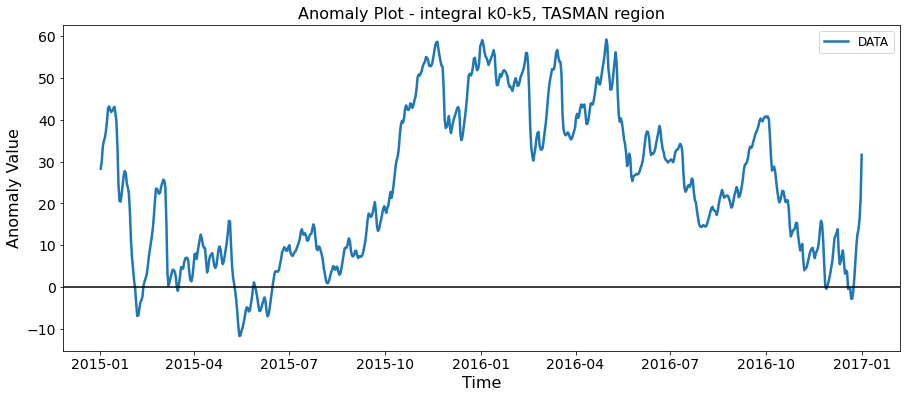

In [350]:
for k_value in range(1):
    # Create a new figure for each layer
    plt.figure(figsize=(15, 6))
    label = 'DATA'
    for varname in varname_data:
        climo = eval(varname).groupby('time.dayofyear').mean('time')
        anom_data = eval(varname).groupby('time.dayofyear') - climo
        cut_data_anom = anom_data.sel(time=slice(start_time_plot, end_time_plot))

        layer_data_anom = cut_data_anom#.sel(k=k_value)
        plt.plot(layer_data_anom['time'], layer_data_anom, label=label, linewidth=2.5)

#     plt.ylim(-1E-5, 1E-5)
    plt.title(f'Anomaly Plot - integral k0-k5, {title_tag} region', fontsize = 16)
    plt.xlabel('Time', fontsize = 16)
    plt.ylabel('Anomaly Value', fontsize = 16)
    plt.axhline(y=0, color='k')
    plt.legend()
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 12)
    
#     # Save or show the figure
    plt.savefig(plot_path + f'DATA_anomalies_lineplot_layer_k{k_value}_{title_tag}_region.png', dpi=1000)
#     plt.show()

## Calculate cumulative sum between k_min and k_max 


In [351]:
k_min = 0
k_max = 5 # 5 max 9

thickness = np.abs(np.diff(Z_depth))
thickness = np.abs(np.diff(Z_depth))[k_min:k_max]

In [352]:
varnames_plot = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_forcing_1992_2017_k0_k9_box_wgtd_avg',
 'DATA_1992_2017_k0_k9_box_wgtd_avg']

varnames_plot = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
 'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
 'G_forcing_1992_2017_k0_k9_box_wgtd_avg']

In [353]:
path_2save_mat = '/Users/jacoposala/Desktop/CU/3.RESEARCH/NASA_project/NEW_heatBudgetECCO/code/line_plots/mat_files'
for ivar in varnames_plot:
    data_all = {}
    data = copy.deepcopy(eval(ivar))
    data_all['data_dayofyear'] = data.time.dt.dayofyear.values
    data_all['data_month'] = data.time.dt.month.values
    data_all['data_year'] = data.time.dt.year.values
    data_all['data_day'] = data.time.dt.day.values
    data_all['data'] = data.values
    savemat(f"{path_2save_mat}/{ivar}_{title_tag}.mat", data_all)


In [354]:
# Define your file paths and variable names
var_names = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
             'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
             'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
             'G_forcing_1992_2017_k0_k9_box_wgtd_avg',
             'DATA_1992_2017_k0_k9_box_wgtd_avg']

# Loop over variables
for var_name in var_names:
    # Load data
    bfr = scipy.io.loadmat(f'{path_2save_mat}/{var_name}_{title_tag}.mat')
    data = bfr['data']
    
    # Ensure the data array is 2D
    if data.ndim != 2:
        raise ValueError(f"Data array should be 2D. Current dimensions are: {data.shape}")
    
    # Transpose data if it's a single row and needs to be processed column-wise
    if data.shape[0] == 1:
        data = data.T  # Now data will be (9495, 1)
    
    # Initialize array for climatology
    bfr_data_climo = np.empty_like(data) * np.nan
    
    # Get day of the year, month, and day information
    day_of_year = bfr['data_dayofyear'][0]
    month = bfr['data_month'][0]
    day = bfr['data_day'][0]
    
    # Loop over each day of the year
    for i in range(len(day_of_year)):
        # Create a mask for the specific day and month
        msk = np.logical_and(month == month[i], day == day[i])
        
        # Debug print to check mask shape
#         print(f"Mask shape: {msk.shape}, Data shape: {data.shape}")
        
        # Ensure mask is the right shape
        if len(msk) != data.shape[0]:
            raise ValueError("The length of the mask does not match the first dimension of data.")
        
        # Extract the masked data for the specific day and calculate the climatological average
        masked_data = data[msk]
        if masked_data.size > 0:
            climatology_avg = np.nanmean(masked_data, axis=0)
            bfr_data_climo[msk] = climatology_avg
    
    # Handle February 29 data
    msk_feb29 = np.logical_and(month == 2, day == 29)
    index = np.where(msk_feb29)[0]

    for i_ind in index:
        if i_ind > 0 and i_ind < len(bfr_data_climo) - 1:
            bfr_data_climo[i_ind, :] = (bfr_data_climo[i_ind - 1, :] + bfr_data_climo[i_ind + 1, :]) / 2
    
    # Optional interpolation for Feb 29, Feb 28, and Mar 1
    # Uncomment if needed
    # for iday, imonth in zip([28, 29, 1], [2, 2, 3]):
    #     msk_feb28_feb29_mar1 = np.logical_and(month == imonth, day == iday)
    #     bfr_data_climo[msk_feb28_feb29_mar1, :] = np.nan
    
    #     for ilev in np.arange(0, np.shape(bfr_data_climo)[1]):
    #         msk = np.isfinite(bfr_data_climo[:, ilev])
    #         xint = np.arange(0, np.shape(bfr_data_climo)[0])
    #         bfr_data_climo[:, ilev] = pchip_interpolate(xint[msk], bfr_data_climo[msk, ilev], xint)
    
    # Prepare output dictionary
    bfr_4_output = {
        'data': data,
        'data_dayofyear': bfr['data_dayofyear'],
        'data_month': bfr['data_month'],
        'data_year': bfr['data_year'],
        'data_day': bfr['data_day'],
        'data_climo': bfr_data_climo
    }

    # Use variable name as key in the output dictionary
    globals()[var_name] = bfr_4_output

In [355]:
# # this worked with input files with 10 levels
# from scipy.interpolate import pchip_interpolate
# # var_names = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
# #  'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
# #  'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
# #  'G_forcing_1992_2017_k0_k9_box_wgtd_avg',
# #  'DATA_1992_2017_k0_k9_box_wgtd_avg']
# var_names = ['G_total_1992_2017_k0_k9_box_wgtd_avg',
#  'G_advection_conv_1992_2017_k0_k9_box_wgtd_avg',
#  'G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg',
#  'G_forcing_1992_2017_k0_k9_box_wgtd_avg',
#             'DATA_1992_2017_k0_k9_box_wgtd_avg']

# # var_names = ['DATA_1992_2017_k0_k9_box_wgtd_avg']
# # Loop over variables
# for var_name in var_names:
#     # Load data
#     bfr = scipy.io.loadmat(path_2save_mat + '/' + var_name + '_' + title_tag + '.mat')
#     data = bfr['data']

#     # Initialize array for climatology
#     bfr_data_climo = np.empty_like(data) * np.nan
    
#     # Loop over each day of the year
#     for i in range(len(bfr['data_dayofyear'][0])):

#         # Create a mask for the specific day and month
#         msk = np.logical_and(bfr['data_month'] == bfr['data_month'][0][i], bfr['data_day'] == bfr['data_day'][0][i])

#         # Repeat msk 10 times along the second axis
#         msk_repeated = np.broadcast_to(msk.T, data.shape)
#         # Apply the repeated mask to each column of the data array
#         masked_data = data[msk_repeated].reshape(-1, data.shape[1])

#         # Calculate climatological average for the specific day and assign to the mask
#         bfr_data_climo[np.where(msk_repeated)] = np.tile(np.nanmean(masked_data, axis=0), (np.sum(msk), 1)).ravel()
    
#     # mask for Feb 29 - we average previous day (Feb 28) and following day (Mar 1)
#     msk_feb29 = np.logical_and(bfr['data_month'][0] == 2, bfr['data_day'][0] == 29)

#     index = np.where(msk_feb29)[0]

#     for i_ind in np.arange(0,len(index)):
#         bfr_data_climo[index[i_ind],:] = (bfr_data_climo[index[i_ind]-1,:] + bfr_data_climo[index[i_ind]+1,:])/2
# #         bfr_data_climo[index[i_ind],:] = bfr_data_climo[index[i_ind]-1,:]
    
        
#     # interpolation for Feb 29, Feb 28 and Mar 1 (between Feb 27 and Mar 2)
# #     else:
# #         for iday, imonth in zip([28,29,1], [2,2,3]):
# #             msk_feb28_feb29_mar1 = np.logical_and(bfr['data_month'][0] == imonth, bfr['data_day'][0] == iday)
# #             bfr_data_climo[msk_feb28_feb29_mar1,:] = np.nan
    
# #         for ilev in np.arange(0, np.shape(bfr_data_climo)[1]):
# #             msk = np.isfinite(bfr_data_climo[:, ilev])
# #             xint = np.arange(0, np.shape(bfr_data_climo)[0])
# #             bfr_data_climo[:,ilev] = scipy.interpolate.pchip_interpolate(xint[msk], \
# #                                                bfr_data_climo[msk, ilev], xint)
    
    
    
#     # Prepare output dictionary
#     bfr_4_output = {
#         'data': data,
#         'data_dayofyear': bfr['data_dayofyear'],
#         'data_month': bfr['data_month'],
#         'data_year': bfr['data_year'],
#         'data_day': bfr['data_day'],
#         'data_climo': bfr_data_climo
#     }

#     # Use variable name as key in the output dictionary
#     globals()[var_name] = bfr_4_output
        

# Load ECCO output from Matlab MHWs code

In [356]:
file_path_ecco = f'/Users/jacoposala/Downloads/MHWs_data_ouput_Aug16/ECCO_daily_avg_box_{title_tag}_1992_2017/ECCOv4r4_heat_daily_box_1992_2017_prcnt90_smooth_noTrend_minLen_5tsteps_maxGap_2tsteps_withAVE.mat'

# Load the data selected above
mat_data_ecco = h5py.File(file_path_ecco, 'r')

# List the keys in the file
# print("Keys in the file:", list(mat_data.keys()))

# Access the data under the key '#refs#'
refs_data_ecco = mat_data_ecco['#refs#']

# Access the data under the key 'find_MHWs_info'
find_mhws_info_data_ecco = mat_data_ecco['find_MHWs_info']

find_mhws_info_data_ecco_ecco.keys()

data_used4MHWs_matlab = find_mhws_info_data_ecco['data_used4MHWs'].value
G_advection_eventAve_matlab = find_mhws_info_data_ecco['G_advection_eventAve'].value
G_forcing_eventAve_matlab = find_mhws_info_data_ecco['G_forcing_eventAve'].value
G_diffusion_eventAve_matlab = find_mhws_info_data_ecco['G_diffusion_eventAve'].value
G_total_eventAve_matlab = find_mhws_info_data_ecco['G_total_eventAve'].value


G_total_1992_2017_k0_k9_box_wgtd_avg
G_advection_conv_1992_2017_k0_k9_box_wgtd_avg
G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg
G_forcing_1992_2017_k0_k9_box_wgtd_avg


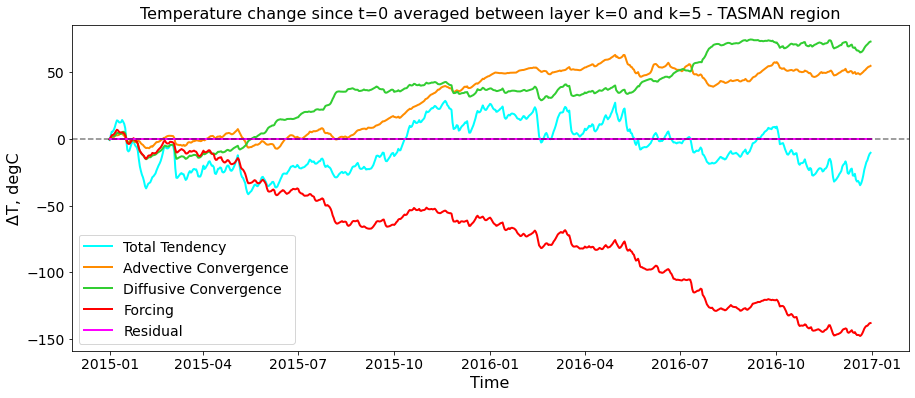

In [357]:
# Make plots for OHC (k0-k5) output from Matlab

ind = 0
start_time = datetime.strptime(start_time_plot, '%Y-%m-%d').toordinal()
end_time = datetime.strptime(end_time_plot, '%Y-%m-%d').toordinal()

# cols = plt.cm.jet(np.linspace(0, 1, len(var_names)))
cols = ['aqua', 'darkorange', 'limegreen', 'red', 'black']

labels = []
for ivar in varnames_plot:
    if 'G_total' in ivar:
        labels.append('Total Tendency')
    if 'G_forcing' in ivar:
        labels.append('Forcing')
    if 'G_adv' in ivar:
        labels.append('Advective Convergence')
    if 'G_diff' in ivar:
        labels.append('Diffusive Convergence')
    if 'DATA' in ivar:
        labels.append('ΔT')
        
plt.figure(figsize=(15,6))      
for ivar in range(len(varnames_plot)):
    print(varnames_plot[ivar])
    d2plot = eval(varnames_plot[ivar])

    d2plot_dnum = [datetime(*d).toordinal() for d in zip(d2plot['data_year'][0], d2plot['data_month'][0], d2plot['data_day'][0])]
    d2plot_msk = (np.array(d2plot_dnum) >= start_time) & (np.array(d2plot_dnum) <= end_time)
    
    d2plot_val = d2plot['data'] - d2plot['data_climo']
    d2plot_val_sel = d2plot_val[d2plot_msk]
    
    
#     d2plot_val_sel = ((d2plot_val_sel[:, k_min+1:k_max+1] + d2plot_val_sel[:, k_min:k_max])
#                         * thickness).sum(axis=1) / 2
    
    
    ordinal_dates = np.array(d2plot_dnum)[d2plot_msk]
    
    datetime_time = [datetime.fromordinal(date) for date in ordinal_dates]

    
    if 'DATA' in var_names[ivar]:
        plt.plot(datetime_time, d2plot_val_sel - d2plot_val_sel[0], color=cols[ivar], label='ΔT', linewidth=1.5, linestyle='--')
    else:
        plt.plot(datetime_time, np.cumsum(d2plot_val_sel) * 24 * 3600, color=cols[ivar], label=labels[ivar], linewidth=2, linestyle='-')

# Add residuals to plot
plt.plot(datetime_time, res_2_all_box_wgt_area_avg.sel(time=slice(start_time_plot, end_time_plot)), color='fuchsia', label='Residual', linewidth=2, linestyle='-')

plt.title(f'Temperature change since t=0 averaged between layer k=0 and k=5 - {title_tag} region', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('ΔT, degC', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.ylim(-2,+1)
# plt.ylim(-.3,.3)
# plt.ylim(-.4,.4)
plt.axhline (y = 0, color = 'k', linestyle = '--', alpha = 0.5, linewidth = 1.5)
plt.legend(fontsize=14)
plt.savefig(plot_path + f'temperature_change_lineplot_layer_k0_k5_{title_tag}_region.png', dpi=1000)
plt.show()


G_total_1992_2017_k0_k9_box_wgtd_avg
G_advection_conv_1992_2017_k0_k9_box_wgtd_avg
G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg
G_forcing_1992_2017_k0_k9_box_wgtd_avg


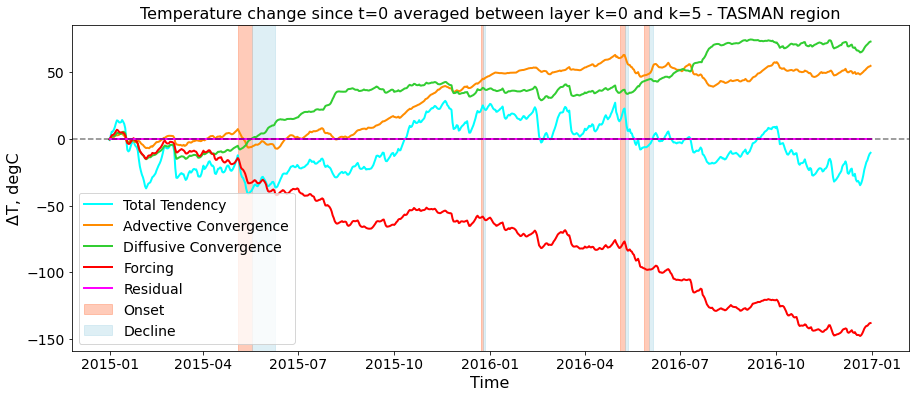

In [358]:
# Plot cumulative sum of heat budget terms with onset/decline phases in background
ind = 0
start_time = datetime.strptime(start_time_plot, '%Y-%m-%d').toordinal()
end_time = datetime.strptime(end_time_plot, '%Y-%m-%d').toordinal()

cols = ['aqua', 'darkorange', 'limegreen', 'red', 'black']

labels = []
for ivar in varnames_plot:
    if 'G_total' in ivar:
        labels.append('Total Tendency')
    if 'G_forcing' in ivar:
        labels.append('Forcing')
    if 'G_adv' in ivar:
        labels.append('Advective Convergence')
    if 'G_diff' in ivar:
        labels.append('Diffusive Convergence')
    if 'DATA' in ivar:
        labels.append('ΔT')

plt.figure(figsize=(15,6))      
for ivar in range(len(varnames_plot)):
    print(varnames_plot[ivar])
    d2plot = eval(varnames_plot[ivar])

    d2plot_dnum = [datetime(*d).toordinal() for d in zip(d2plot['data_year'][0], d2plot['data_month'][0], d2plot['data_day'][0])]
    d2plot_msk = (np.array(d2plot_dnum) >= start_time) & (np.array(d2plot_dnum) <= end_time)
    
    d2plot_val = d2plot['data'] - d2plot['data_climo']
    d2plot_val_sel = d2plot_val[d2plot_msk]
    
#     d2plot_val_sel = ((d2plot_val_sel[:, k_min+1:k_max+1] + d2plot_val_sel[:, k_min:k_max])
#                         * thickness).sum(axis=1) / 2
    
    ordinal_dates = np.array(d2plot_dnum)[d2plot_msk]
    datetime_time = [datetime.fromordinal(date) for date in ordinal_dates]
    
    if 'DATA' in varnames_plot[ivar]:
        plt.plot(datetime_time, d2plot_val_sel - d2plot_val_sel[0], color=cols[ivar], label='ΔT', linewidth=1.5, linestyle='--')
    else:
        plt.plot(datetime_time, np.cumsum(d2plot_val_sel) * 24 * 3600, color=cols[ivar], label=labels[ivar], linewidth=2, linestyle='-')

# Add residuals to plot
plt.plot(datetime_time, res_2_all_box_wgt_area_avg.sel(time=slice(start_time_plot, end_time_plot)), color='fuchsia', label='Residual', linewidth=2, linestyle='-')

# Convert find_mhws_info_data_ecco to datetime format
mhws_dates = np.arange(len(find_mhws_info_data_ecco['onset_duration_in_tsteps']))
mhws_dnum = [datetime.fromordinal(start_time + int(d)) for d in mhws_dates]

onset_durations = find_mhws_info_data_ecco['onset_duration_in_tsteps'].value[:,0,0]
events_durations = find_mhws_info_data_ecco['events_duration_in_tsteps'].value[:,0,0]

# Define the mask for the onset and decline phases
date_msk = (pd.Series(mhws_dnum) >= pd.to_datetime(start_time_plot)) & (pd.Series(mhws_dnum) <= pd.to_datetime(end_time_plot))
onset_durations = onset_durations[date_msk]
events_durations = events_durations[date_msk]

# Create shaded regions for onset and decline phases
label_tag = True
for i in range(len(onset_durations)):
    if not np.isnan(onset_durations[i]) and not np.isnan(events_durations[i]):
        onset_start = mhws_dnum[i]
        onset_end = datetime.fromordinal(start_time + int(mhws_dates[i] + onset_durations[i] - 1))
        decline_start = onset_end
        decline_end = datetime.fromordinal(start_time + int(mhws_dates[i] + events_durations[i] - 1))
        
        # Plot onset phase 
        plt.axvspan(onset_start, onset_end, color='coral', alpha=0.4, label='Onset' if label_tag else "")
        
        # Plot decline phase 
        plt.axvspan(decline_start, decline_end, color='lightblue', alpha=0.4, label='Decline' if label_tag else "")
        label_tag = False

plt.title(f'Temperature change since t=0 averaged between layer k={k_min} and k={k_max} - {title_tag} region', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('ΔT, degC', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(-.25, .25)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1.5)
plt.legend(fontsize=14)
plt.savefig(plot_path + f'temperature_change_lineplot_layer_k0_k5_with_onset_decline_{title_tag}_region.png', dpi=1000)
plt.show()


In [359]:
ciao

NameError: name 'ciao' is not defined

# Plot ECCO and OISST timeseries of DATA (OHC) with percentiles

In [ ]:
file_path_oisst = f'/Users/jacoposala/Downloads/MHWs_data_ouput_Aug16/OISST_daily_avg_box_{title_tag}_1992_2017/oisst_v2_1992_2017_prcnt90_smooth_noTrend_minLen_5tsteps_maxGap_2tsteps_withAVE.mat'

# Load the data selected above
mat_data_oisst = h5py.File(file_path_oisst, 'r')

# Access the data under the key 'find_MHWs_info'
find_mhws_info_data_oisst = mat_data_oisst['find_MHWs_info']

find_mhws_info_data_oisst.keys()

data_used4MHWs_matlab = find_mhws_info_data_oisst['data_used4MHWs'].value


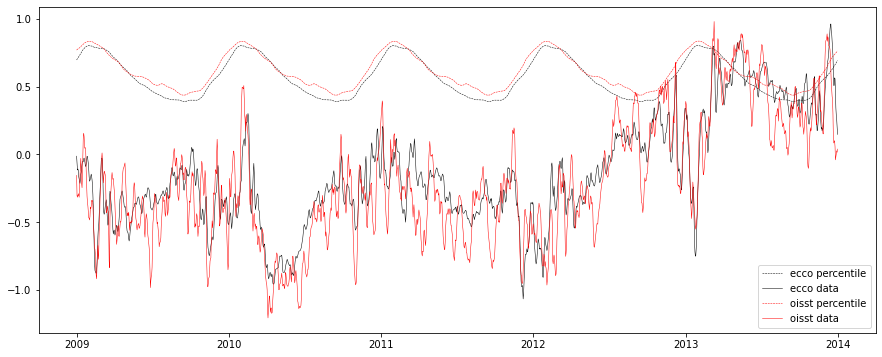

In [316]:
plt.figure(figsize=(15,6))
plt.plot(datetime_time, find_mhws_info_data_ecco['data_percentile3d'][:,0,0][date_msk], color = 'k', linestyle = '--', linewidth = .5, label = 'ecco percentile')
plt.plot(datetime_time, find_mhws_info_data_ecco['data_used4MHWs'][:,0,0][date_msk], color = 'k', linewidth = .5, label = 'ecco data')
plt.plot(datetime_time, find_mhws_info_data_oisst['data_percentile3d'][1:-1,0,0][date_msk], color = 'red', linestyle = '--', linewidth = .5, label = 'oisst percentile')
plt.plot(datetime_time, find_mhws_info_data_oisst['data_used4MHWs'][1:-1,0,0][date_msk], color = 'red', linewidth = .5, label = 'oisst data')
plt.legend()


## Make plots for each layer 


G_total_1992_2017_k0_k9_box_wgtd_avg
G_advection_conv_1992_2017_k0_k9_box_wgtd_avg
G_diffusion_conv_1992_2017_k0_k9_box_wgtd_avg
G_forcing_1992_2017_k0_k9_box_wgtd_avg


IndexError: too many indices

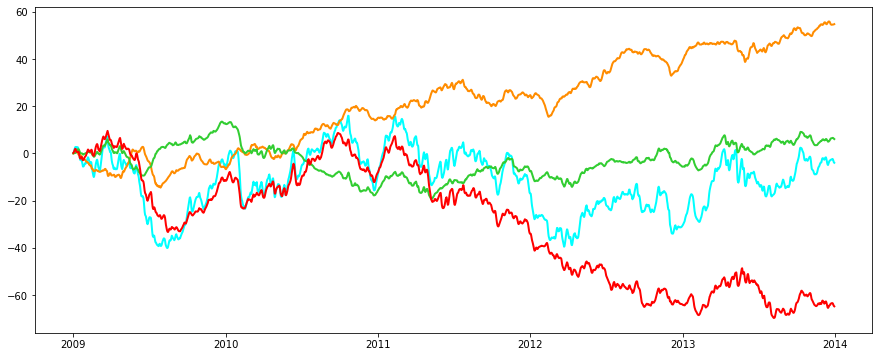

In [317]:
# Make plots for each layer 

k_lev = [0,1,2,3,4,5]

# start_time_plot = '1992-01-02'
# end_time_plot = '1992-12-31'

start_time = datetime.strptime(start_time_plot, '%Y-%m-%d').toordinal()
end_time = datetime.strptime(end_time_plot, '%Y-%m-%d').toordinal()

# cols = plt.cm.jet(np.linspace(0, 1, len(var_names)))
cols = ['aqua', 'darkorange', 'limegreen', 'red', 'black']

labels = []
for ivar in varnames_plot:
    if 'G_total' in ivar:
        labels.append('Total Tendency')
    if 'G_forcing' in ivar:
        labels.append('Forcing')
    if 'G_adv' in ivar:
        labels.append('Advective Convergence')
    if 'G_diff' in ivar:
        labels.append('Diffusive Convergence')
    if 'DATA' in ivar:
        labels.append('ΔT')
        
for i_k in k_lev:
    plt.figure(figsize=(15,6))      
    for ivar in range(len(varnames_plot)):
        print(varnames_plot[ivar])
        d2plot = eval(varnames_plot[ivar])

        d2plot_dnum = [datetime(*d).toordinal() for d in zip(d2plot['data_year'][0], d2plot['data_month'][0], d2plot['data_day'][0])]
        d2plot_msk = (np.array(d2plot_dnum) >= start_time) & (np.array(d2plot_dnum) <= end_time)

        d2plot_val = d2plot['data'][:,i_k] - d2plot['data_climo'][:,i_k]
        d2plot_val_sel = d2plot_val[d2plot_msk]


        ordinal_dates = np.array(d2plot_dnum)[d2plot_msk]

        datetime_time = [datetime.fromordinal(date) for date in ordinal_dates]


        if 'DATA' in var_names[ivar]:
            plt.plot(datetime_time, d2plot_val_sel - d2plot_val_sel[0], color=cols[ivar], label='ΔT', linewidth=1.5, linestyle='--')
        else:
            plt.plot(datetime_time, np.cumsum(d2plot_val_sel) * 24 * 3600, color=cols[ivar], label=labels[ivar], linewidth=2, linestyle='-')

    # Add residuals to plot
    plt.plot(datetime_time, res_2_all_box_wgt_area_avg.sel(time=slice(start_time_plot, end_time_plot))[:,ind], color='fuchsia', label='Residual', linewidth=2, linestyle='-')

    plt.title(f'Temperature change since t=0 averaged for layer k={i_k} - {title_tag} region', fontsize = 16)
    plt.xlabel('Time', fontsize = 16)
    plt.ylabel('ΔT, degC', fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.axhline (y = 0, color = 'k', linestyle = '--', alpha = 0.5, linewidth = 1.5)
    plt.legend(fontsize=14)
#     plt.xlim(datetime(2012, 2, 1), datetime(2012, 4, 30))  # Set x-axis limits

#     plt.savefig(plot_path + f'temperature_change_lineplot_layer_k{i_k}_{title_tag}_region.png', dpi=1000)
    
    plt.show()
    plt.close()
